This notebook describes how to do non uniform quantization based on the probability density estimation using the values occurrence cumulative sum.

Imports

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import h5py
from multiprocess import Pool
from tqdm import tqdm
import math

import matplotlib
matplotlib.style.use('seaborn')
from ipywidgets import widgets, interactive

import sys
sys.path.append('../')
import nonuniform_quantization

File info (modify according to your environment and dataset)

In [2]:
file_path = '/sdf/home/b/berthie/tmox42619_data/h5files/hits.tmox42619.run135.h5'
good_ports = ['port_0','port_1','port_4','port_5','port_12','port_13','port_14','port_15']

Input data

In [3]:
f = h5py.File(file_path, 'r')

raw_tofs = []
for port in good_ports:
    temp = np.asarray(f[port]['tofs'][1:])
    raw_tofs.append(temp-temp.min())      # I subtract the minimum value so it shifts the spectrum "left"

Cumulative sum

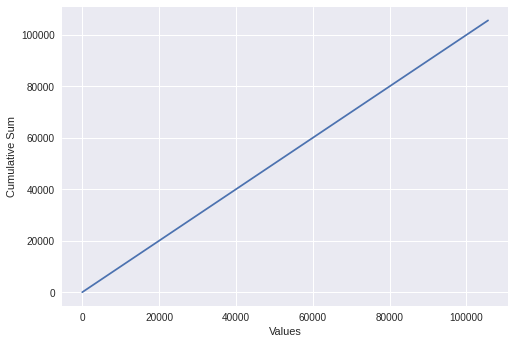

In [4]:
port = 0    # for the sake of the example, I only use one port.

all_samples = raw_tofs[port]
values, counts = np.unique(all_samples, return_counts=True)
cum_counts = np.cumsum(counts)

plt.plot(cum_counts)
plt.xlabel('Values')
plt.ylabel('Cumulative Sum')
plt.show()

What we see a linear cumulative sum. This is because the distribution is so sparse, every value only appears once per port per run. To compensate that we already need to uniformly quantize the set. By doing so, we will have a first density estimation to do the cumulative sum nonuniform quantization. Note that this first estimation can also be performed with the Lloyd-Max algo as shown in <optimized_quantization_tutorial.ipynb>

First density estimation with uniform quantization. You can change the number of bit (n) for the uniform quantization and see the effect on the cumulative sum using the slider in the widget bellow.

In [5]:
def uniform_quantization_cumsum_effect_visualisation(n): 
    Q = nonuniform_quantization.quantizer(Nb_bits=n)
    uni_density_estimation = Q.quantization(all_samples, np.linspace(all_samples.min(), all_samples.max(), num=1+2**n)[1:])

    values, counts = np.unique(uni_density_estimation, return_counts=True)
    cum_counts = np.cumsum(counts)
    cum_counts_prime = np.gradient(cum_counts)

    # We use a decimation step "delta" to decimate cum_counts
    smaller_n = math.floor(math.log2(math.floor(cum_counts.max()/counts.max()))) # this is the highest resolution we can have considering the uniform quantization 

    delta_y = math.ceil(len(cum_counts)/2**smaller_n)
    y_mapping = cum_counts[0:len(cum_counts):delta_y]
    y_mapping_prime = np.gradient(y_mapping)

    #### THIS IS WHERE THE QUANTIZATION HAPPENS ####
    delta_x = math.ceil(len(values)/2**smaller_n)
    x_mapping = values[0:len(values):delta_x] # x_mapping is the nonuniformly quantizated values
    x_mapping_bin_edges = np.append((x_mapping[:-1] + x_mapping[1:])/2, values.max())


    print('Maximum possible bit depth\n for the nonuniform quantizer: ', smaller_n)

    fig, axes = plt.subplots(2, 2)
    axes[0][0].plot(cum_counts)
    axes[0][0].set_ylabel('Cumulative Sum')

    axes[1][0].plot(cum_counts_prime)
    axes[1][0].set_xlabel('Index Value')
    axes[1][0].set_ylabel('Cumulative sum derivative')

    axes[0][1].plot(y_mapping)
    axes[1][1].plot(y_mapping_prime)
    axes[1][1].set_xlabel('Index Value')
    
    plt.figure(figsize=(fig.get_size_inches()[0],0.3*fig.get_size_inches()[0]))
    plt.plot(x_mapping_bin_edges,np.ones_like(x_mapping_bin_edges) ,'.')
    plt.title('Nonuniform bin edges distribution')
    plt.xlabel('Bin edges')
    plt.show()

    plt.hist(all_samples, bins=x_mapping_bin_edges)


window_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=25,
    step=1,
    description='n:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

interactive(uniform_quantization_cumsum_effect_visualisation, n=window_slider)

interactive(children=(IntSlider(value=10, continuous_update=False, description='n:', max=25, min=1), Output())…


 * MIT License
 *
 * Copyright (c) 2022 SLAC National Accelerator Laboratory
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in all
 * copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
 * SOFTWARE.
 *
 * Authors : Berthié Gouin-Ferland
 * Last update : 2022-12-08
 *
 * Description : This notebook describes how to do non uniform quantization based on the probability density estimation using the values occurrence cumulative sum.
